In [9]:
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    root_mean_squared_error,
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [10]:
df = sns.load_dataset("titanic")

In [11]:
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [12]:
df.isnull().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

In [13]:
num = df.select_dtypes(exclude=["object", "category", "bool"])
cat = df.select_dtypes(include=["object", "category", "bool"])

<Axes: >

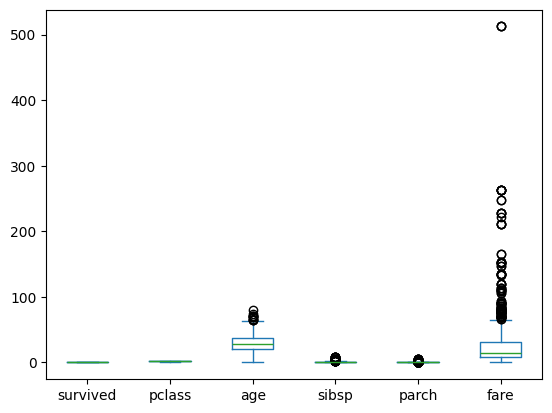

In [17]:
num.plot(kind="box")

In [25]:
si = SimpleImputer(strategy="median")
si2 = SimpleImputer(strategy="most_frequent")

In [27]:
df["age"] = si.fit_transform(df["age"].values.reshape(-1, 1))

In [28]:
df.isnull().sum()

survived         0
pclass           0
sex              0
age              0
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

In [32]:
df[["embarked"]] = si2.fit_transform(df["embarked"].values.reshape(-1, 1))
df[["deck"]] = si2.fit_transform(df["deck"].values.reshape(-1, 1))
df[["embark_town"]] = si2.fit_transform(df["embark_town"].values.reshape(-1, 1))

In [ ]:
# Handling the outliers

In [22]:
def Iqr_Calc(x: pd.Series):
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    upper = q3 + 1.5 * iqr
    lower = q1 - 1.5 * iqr
    return pd.Series(np.where(x > upper, upper, np.where(x < lower, lower, x)))

In [34]:
df["age"] = Iqr_Calc(df["age"])
df["sibsp"] = Iqr_Calc(df["sibsp"])
df["parch"] = Iqr_Calc(df["parch"])
df["fare"] = Iqr_Calc(df["fare"])

In [103]:
# from sklearn.preprocessing import PowerTransformer

# X = df.drop(columns="survived")
# y = df["survived"]

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.33, random_state=42
# )

# num = (
#     df.select_dtypes(exclude=["object", "category", "bool"])
#     .drop(columns="survived")
#     .columns
# )
# cat = df.select_dtypes(include=["object", "category", "bool"]).columns

# cat_pipe = Pipeline(
#     steps=[
#         ("Encoding", OneHotEncoder(drop="first", sparse_output=False)),
#         (
#             "Ordinal_Encoding",
#             OrdinalEncoder(
#                 categories=[df["class"].value_counts().index.values.tolist()]
#             ),
#         ),
#     ]
# )

# num_pipe = Pipeline(steps=[("Normality", PowerTransformer())])

# Preprocess = ColumnTransformer(
#     transformers=[
#         ("Numerical_Pipeline", num_pipe, num),
#         ("Categorical_Pipeline", cat_pipe, cat),
#     ],
#     remainder="passthrough",
# )

# Preprocess.fit_transform(X_train)

In [101]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer, OneHotEncoder, OrdinalEncoder

# Splitting data
X = df.drop(columns="survived")
y = df["survived"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

# Identifying numerical and categorical columns
num_cols = X.select_dtypes(exclude=["object", "category", "bool"]).columns
cat_cols = X.select_dtypes(include=["object", "category", "bool"]).columns

# Numerical pipeline
num_pipe = Pipeline(steps=[("normality", PowerTransformer())])

# Categorical pipeline (handling OneHot and Ordinal separately)
one_hot_cols = [
    col for col in cat_cols if col != "class"
]  # Exclude 'class' for ordinal encoding
ordinal_cols = ["class"]  # Assuming 'class' has an ordinal relationship

cat_pipe = ColumnTransformer(
    transformers=[
        ("onehot", OneHotEncoder(drop="first", sparse_output=False), one_hot_cols),
        (
            "ordinal",
            OrdinalEncoder(categories=[df["class"].value_counts().index.tolist()]),
            ordinal_cols,
        ),
    ]
)

# Full preprocessing pipeline
Preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
    ],
    remainder="passthrough",
)

# Fit and transform
X_train_transformed = Preprocess.fit_transform(X_train)
X_test_transformed = Preprocess.transform(X_test)

ValueError: Shape mismatch: if categories is an array, it has to be of shape (n_features,).